Plot summary of GLiMMIRS-base performance on simulated data (Figure 1D, Table S2).

In [1]:
suppressMessages(library(dplyr))
library(ggplot2)
# suppressMessages(library(BoutrosLab.plotting.general))
library(rhdf5)
library(ggpubr)
library(repr)
library(patchwork)
# Change plot size to BIG
options(repr.plot.width=20, repr.plot.height=10)

# Load performance data


## For perturbation probability $X_{perturb}$
From `/iblm/netapp/data1/jezhou/crisprQTL/sim_performance_true_efficiency_2guides_cont-x1_cont-counts_targeting_pseudocount`.

Here, counts were simulated using perturbation probability for $X_enhancer$. A perturbation probability was also used to model to simulated counts. 

In [6]:
data.dir <- "/iblm/netapp/data1/jezhou/crisprQTL/sim_performance_true_efficiency_2guides_cont-x1_cont-counts_targeting_pseudocount"

# load coefficiency estimates under alt hypothesis (contains guide guide effect estimate)
alt.coeffs.cont.x1 <- read.csv(file.path(data.dir,"alt_coeffs.csv"))
# null.coeffs.cont.x1 <- read.csv(file.path(data.dir,"null_coeffs.csv"))

## For indicator $X_{perturb}$
From `/iblm/netapp/data1/jezhou/crisprQTL/sim_performance_true_efficiency_2guides_indic-x1_cont-counts_targeting_pseudocount`.

Here, counts were simulated using perturbation probability for $X_enhancer$. An indicator variable was used to model to simulated counts. 

In [7]:
data.dir <- "/iblm/netapp/data1/jezhou/crisprQTL/sim_performance_true_efficiency_2guides_indic-x1_cont-counts_targeting_pseudocount"

# load coeff estimates from alt hypothesis 
alt.coeffs.indic.x1 <- read.csv(file.path(data.dir,"alt_coeffs.csv"))

# Plot

Combine performance from two different values of $X_{perturb}$ and plot true vs. estimated coefficient values for each term under these two approaches to compare.

In [8]:
alt.coeffs.indic.x1$X.perturb <- 'indicator'
alt.coeffs.cont.x1$X.perturb <- 'probability'

coeff.estimates.plotdf <- rbind(alt.coeffs.indic.x1, alt.coeffs.cont.x1)

In [9]:
head(coeff.estimates.plotdf)

,term,estimate,true,gene,targeting,X.perturb
,<chr>,<dbl>,<dbl>,<int>,<lgl>,<chr>
1,(Intercept),-0.7510548,-1.308287,1763,TRUE,indicator
2,guide.eff,-0.6704949,-3.952619,1763,TRUE,indicator
3,s.score,1.6401443,2.742498,1763,TRUE,indicator
4,g2m.score,0.9599310,1.600469,1763,TRUE,indicator
5,percent.mito,2.9360305,3.847493,1763,TRUE,indicator
6,(Intercept),1.6306415,1.617682,4286,TRUE,indicator


Calculate Pearson correlation between estimated vs reference values for each term under perturbation probability vs. indicator variable. This generates **Table S2**.

In [10]:
pearson.df <- coeff.estimates.plotdf %>% group_by(term, X.perturb) %>% 
                    summarise(pearsonr=cor.test(estimate, true, method='pearson')$estimate,
                              pval=cor.test(estimate, true, method='pearson')$p.value)

pearson.df

`summarise()` has grouped output by 'term'. You can override using the
`.groups` argument.


term,X.perturb,pearsonr,pval
<chr>,<chr>,<dbl>,<dbl>
(Intercept),indicator,0.9968156,0.000000e+00
(Intercept),probability,0.9968160,0.000000e+00
g2m.score,indicator,0.9827554,0.000000e+00
g2m.score,probability,0.9827534,0.000000e+00
guide.eff,indicator,0.8109335,1.648358e-234
guide.eff,probability,0.8619700,1.070839e-296
percent.mito,indicator,0.9246571,0.000000e+00
percent.mito,probability,0.9246434,0.000000e+00
s.score,indicator,0.9739112,0.000000e+00


Make labeller for facet grid titles.

In [11]:
# Make a modified copy of the original data
plotdf.mod <- coeff.estimates.plotdf %>%
            mutate(across(term, factor, levels=c("(Intercept)","guide.eff","s.score","g2m.score","percent.mito"))) %>%
              mutate(coeff = recode(term,
                "(Intercept)" = "{beta}[0]",
                "guide.eff" = "{beta}[enhancer]",
                "s.score" = "{beta}[S]",
                "g2m.score" = "{beta}[G2M]",
                "percent.mito" = "{beta}[mito]"
              ))


In [12]:
# define group colors
group.colors <- c(`probability` = "#89023E", `indicator` = "#7189FF")

## Make a separate plot for each term

### $\beta_0$

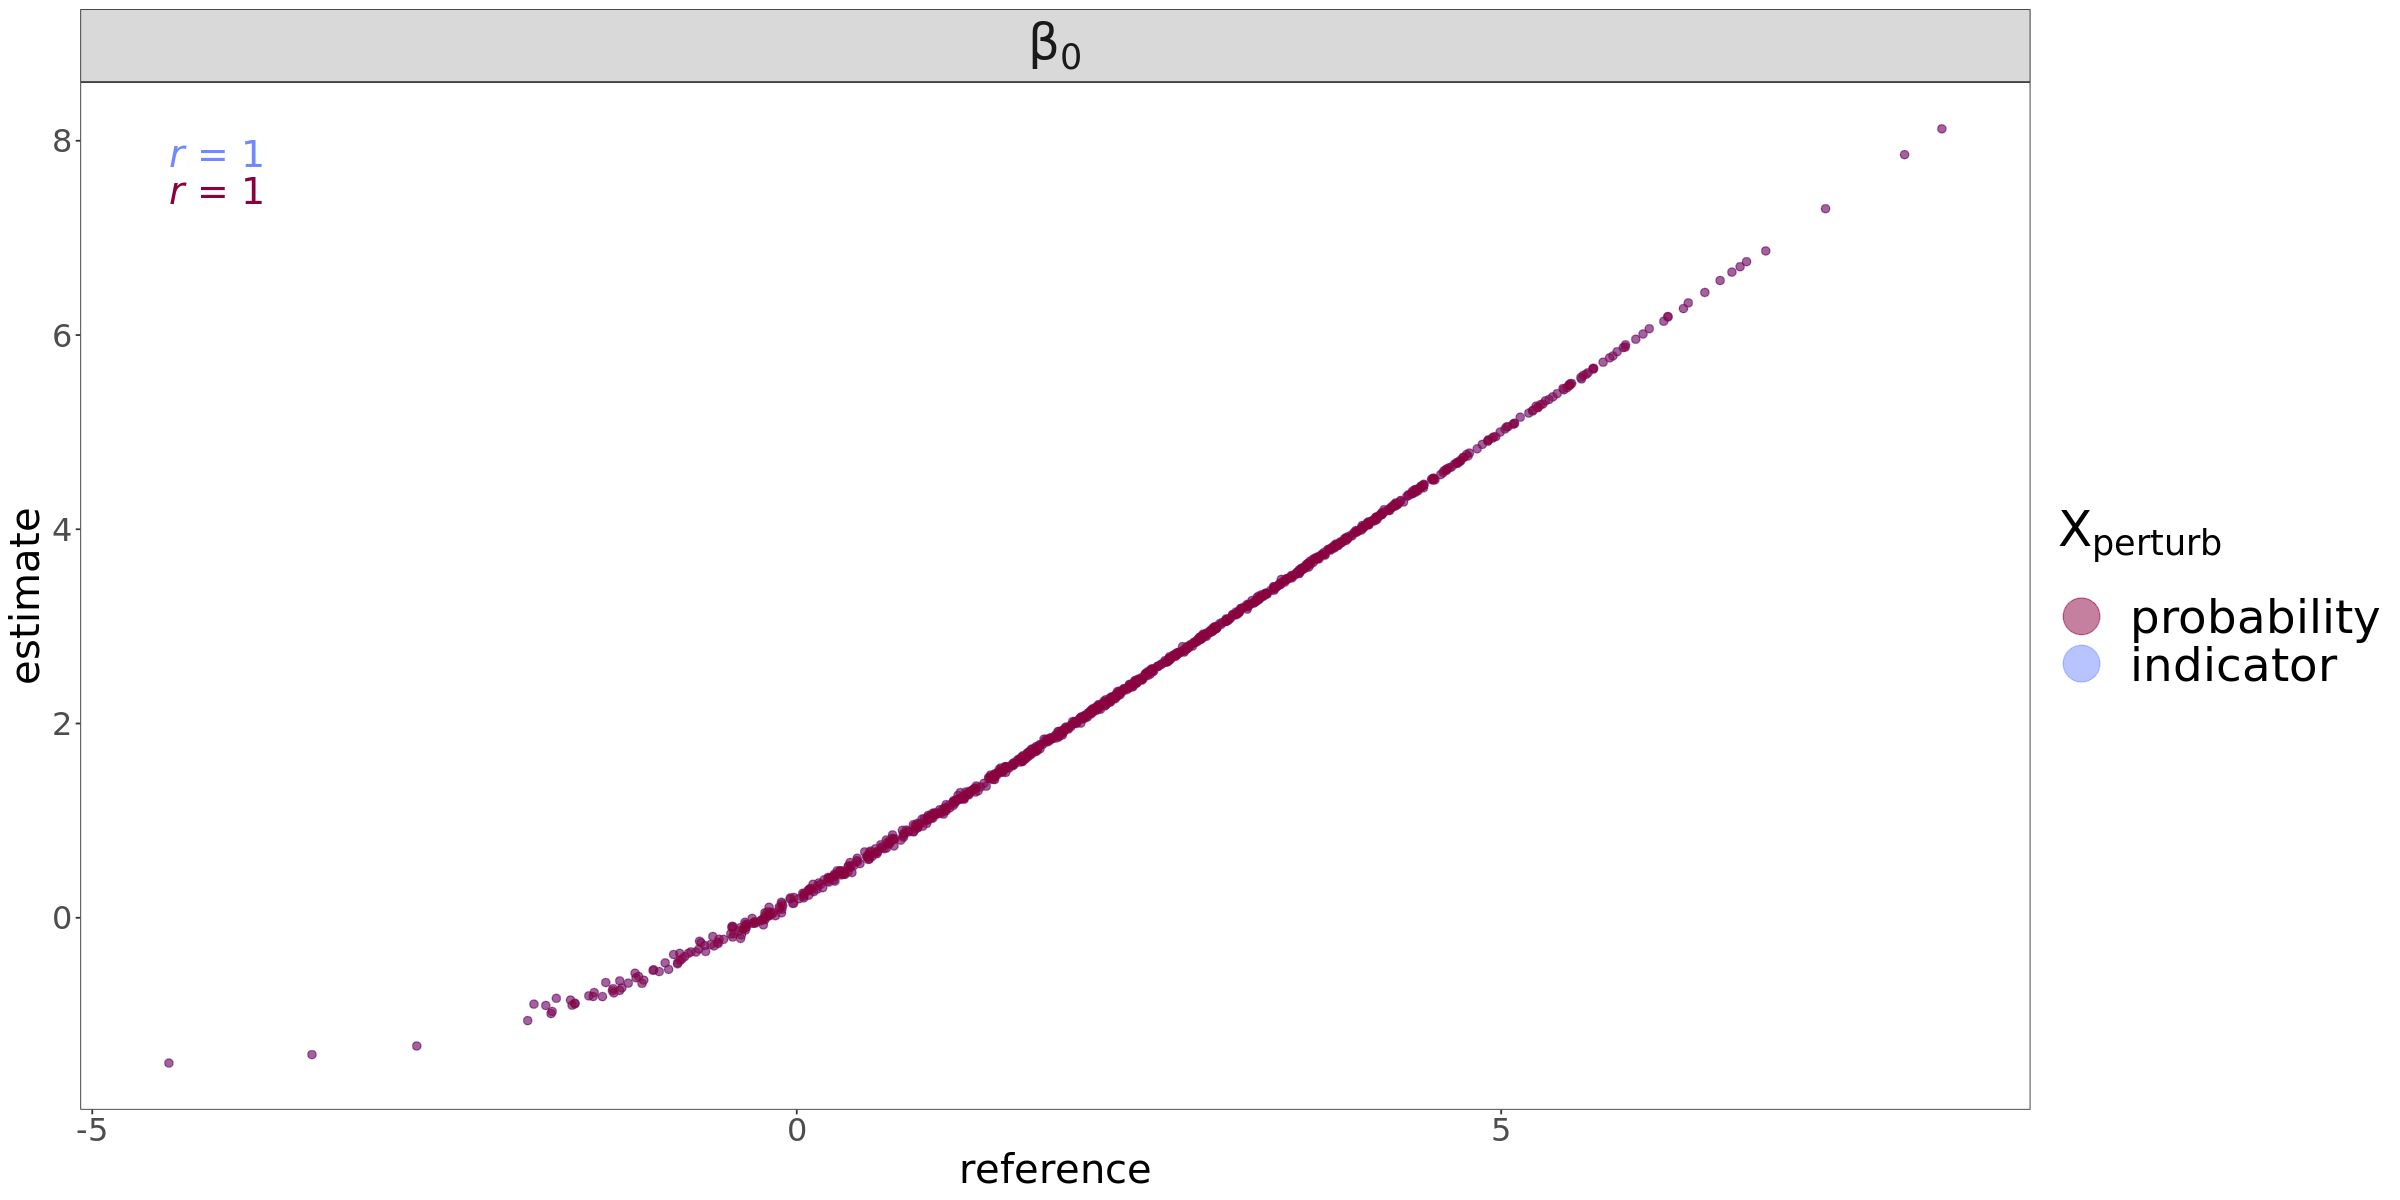

In [13]:
beta0.p <- plotdf.mod %>% filter(term == "(Intercept)") %>% 
            ggscatter(x = "true", y = "estimate", color = "X.perturb", alpha = 0.5) + 
        stat_cor(method = "pearson", aes(color = X.perturb, label = ..r.label..),
                 show.legend = FALSE, geom = "text", 
                 label.y.npc="top", label.x.npc = "left",
                cor.coef.name = "r",
                 size = 8) + 
            facet_grid(cols=vars(coeff), scales = "free", labeller = label_parsed) +
            theme_bw() +
            theme(text = element_text(size = 24),
                 plot.title = element_text(size = 14),
                 strip.text = element_text(size = 30),
                 legend.text = element_text(size = 28),
                 legend.title = element_text(size = 30),
                 panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
            guides(colour = guide_legend(override.aes = list(size=10))) +
            scale_fill_manual(values=group.colors) + 
            scale_color_manual(values = group.colors) +
            labs(color=expression(paste("X"[perturb])), x='reference') 

beta0.p

### $\beta_{enhancer}$

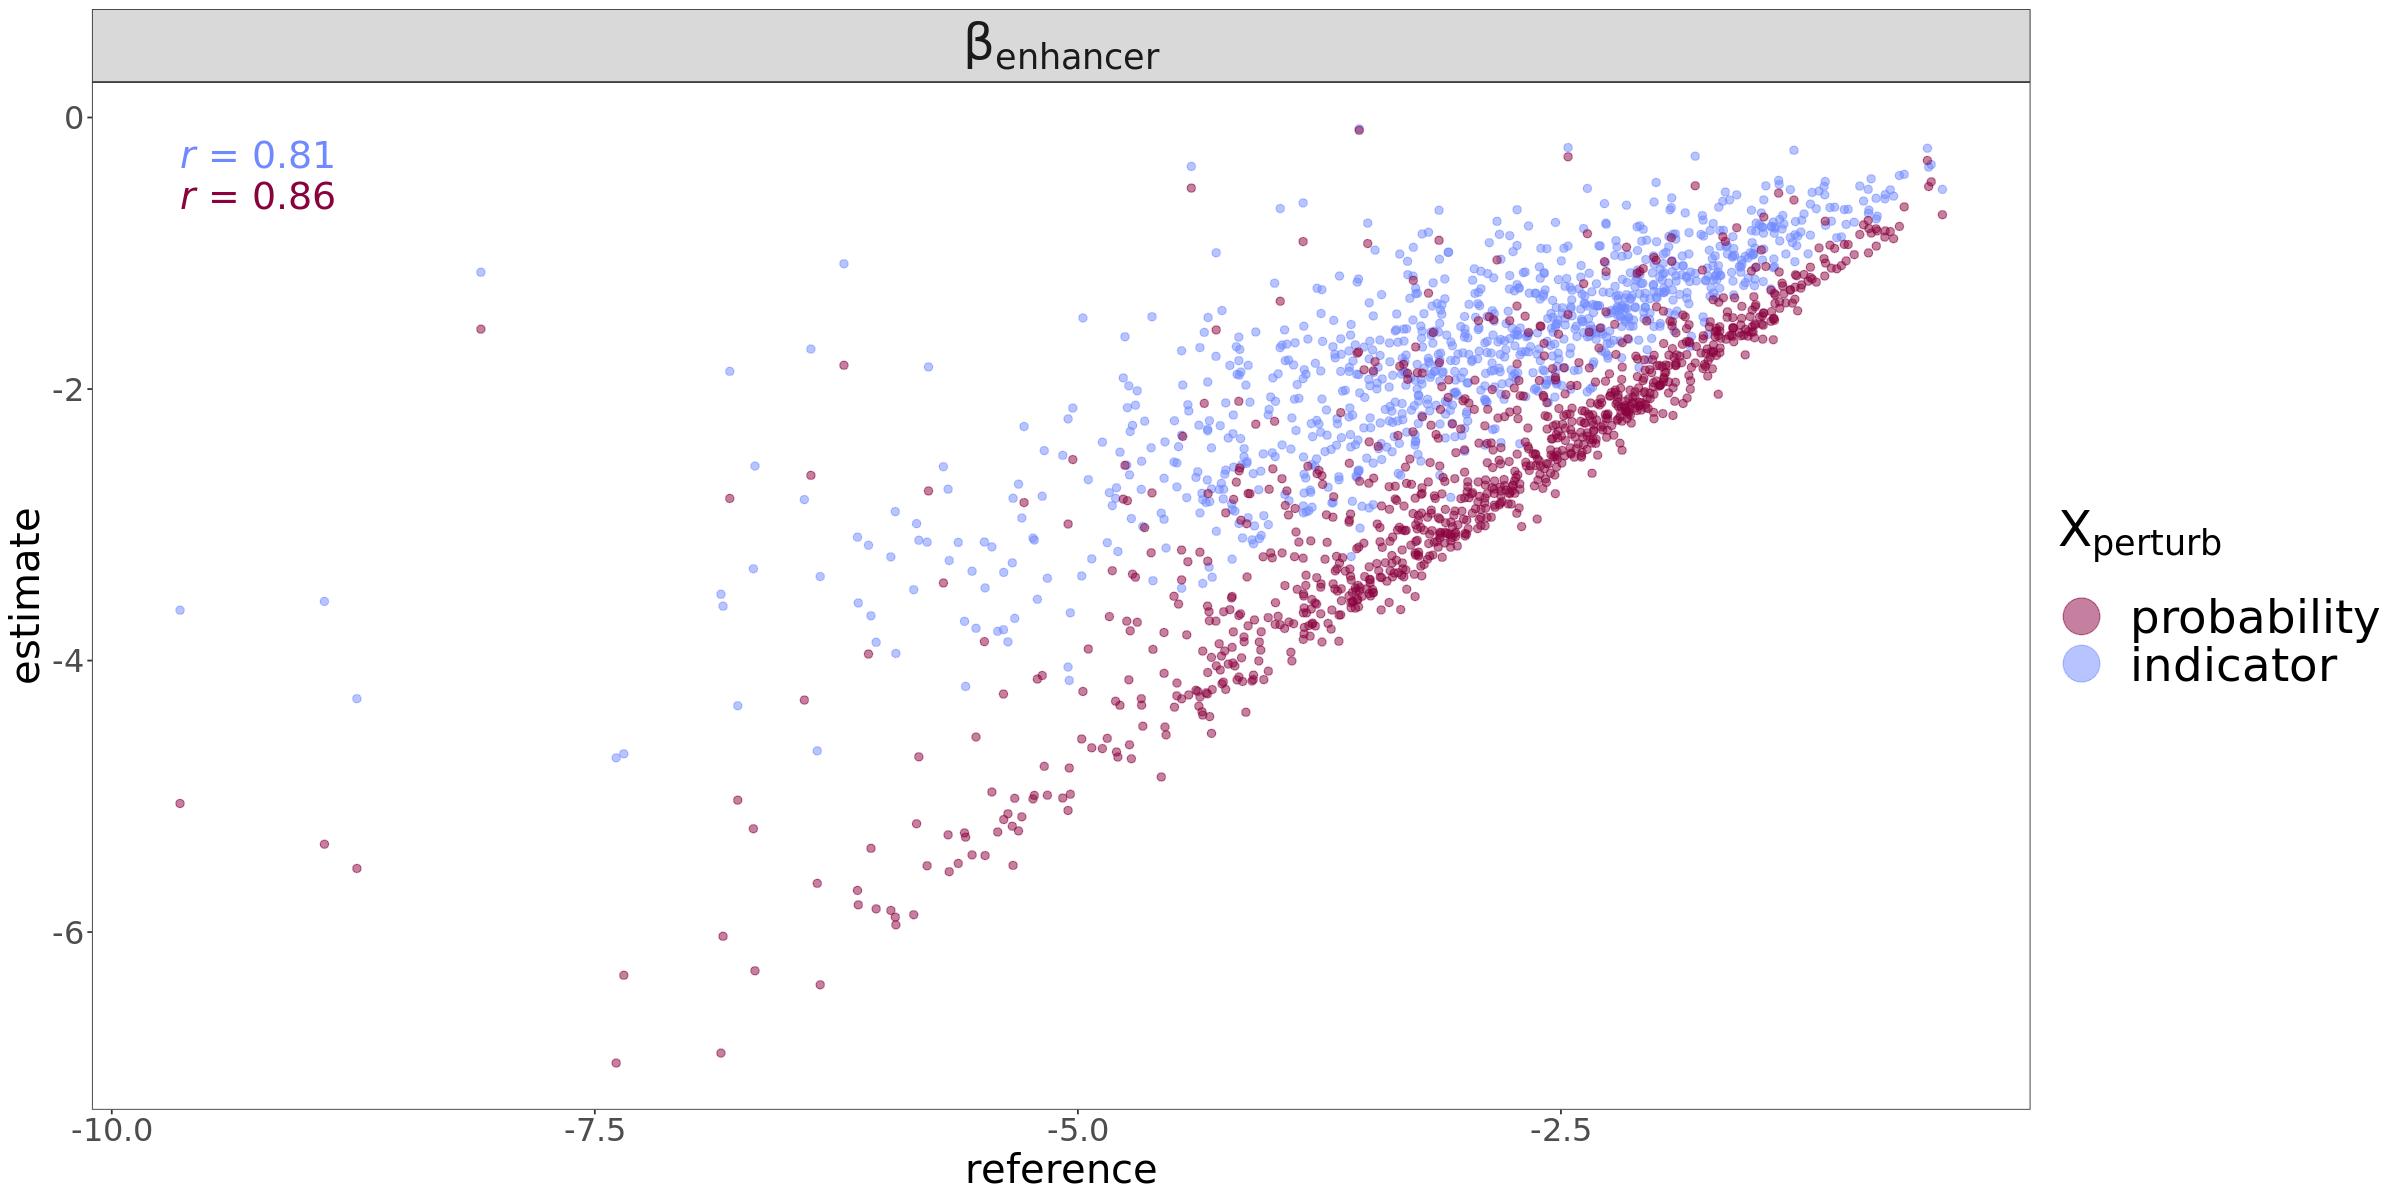

In [14]:
beta.enh.p <- plotdf.mod %>% filter(term == "guide.eff") %>% 
            ggscatter(x = "true", y = "estimate", color = "X.perturb", alpha = 0.5) + 
        stat_cor(method = "pearson", aes(color = X.perturb, label = ..r.label..),
                 show.legend = FALSE, geom = "text", 
                 label.y.npc="top", label.x.npc = "left",
                cor.coef.name = "r",
                 size = 8) + 
            facet_grid(cols=vars(coeff), scales = "free", labeller = label_parsed) +
            theme_bw() +
            theme(text = element_text(size = 24),
                 plot.title = element_text(size = 14),
                 strip.text = element_text(size = 30),
                 legend.text = element_text(size = 28),
                 legend.title = element_text(size = 30),
                 panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
            guides(colour = guide_legend(override.aes = list(size=10))) +
            scale_fill_manual(values=group.colors) + 
            scale_color_manual(values = group.colors) +
            labs(color=expression(paste("X"[perturb])), x='reference') 

beta.enh.p

### $\beta_S, \beta_{G2M}, \beta_{mito}$

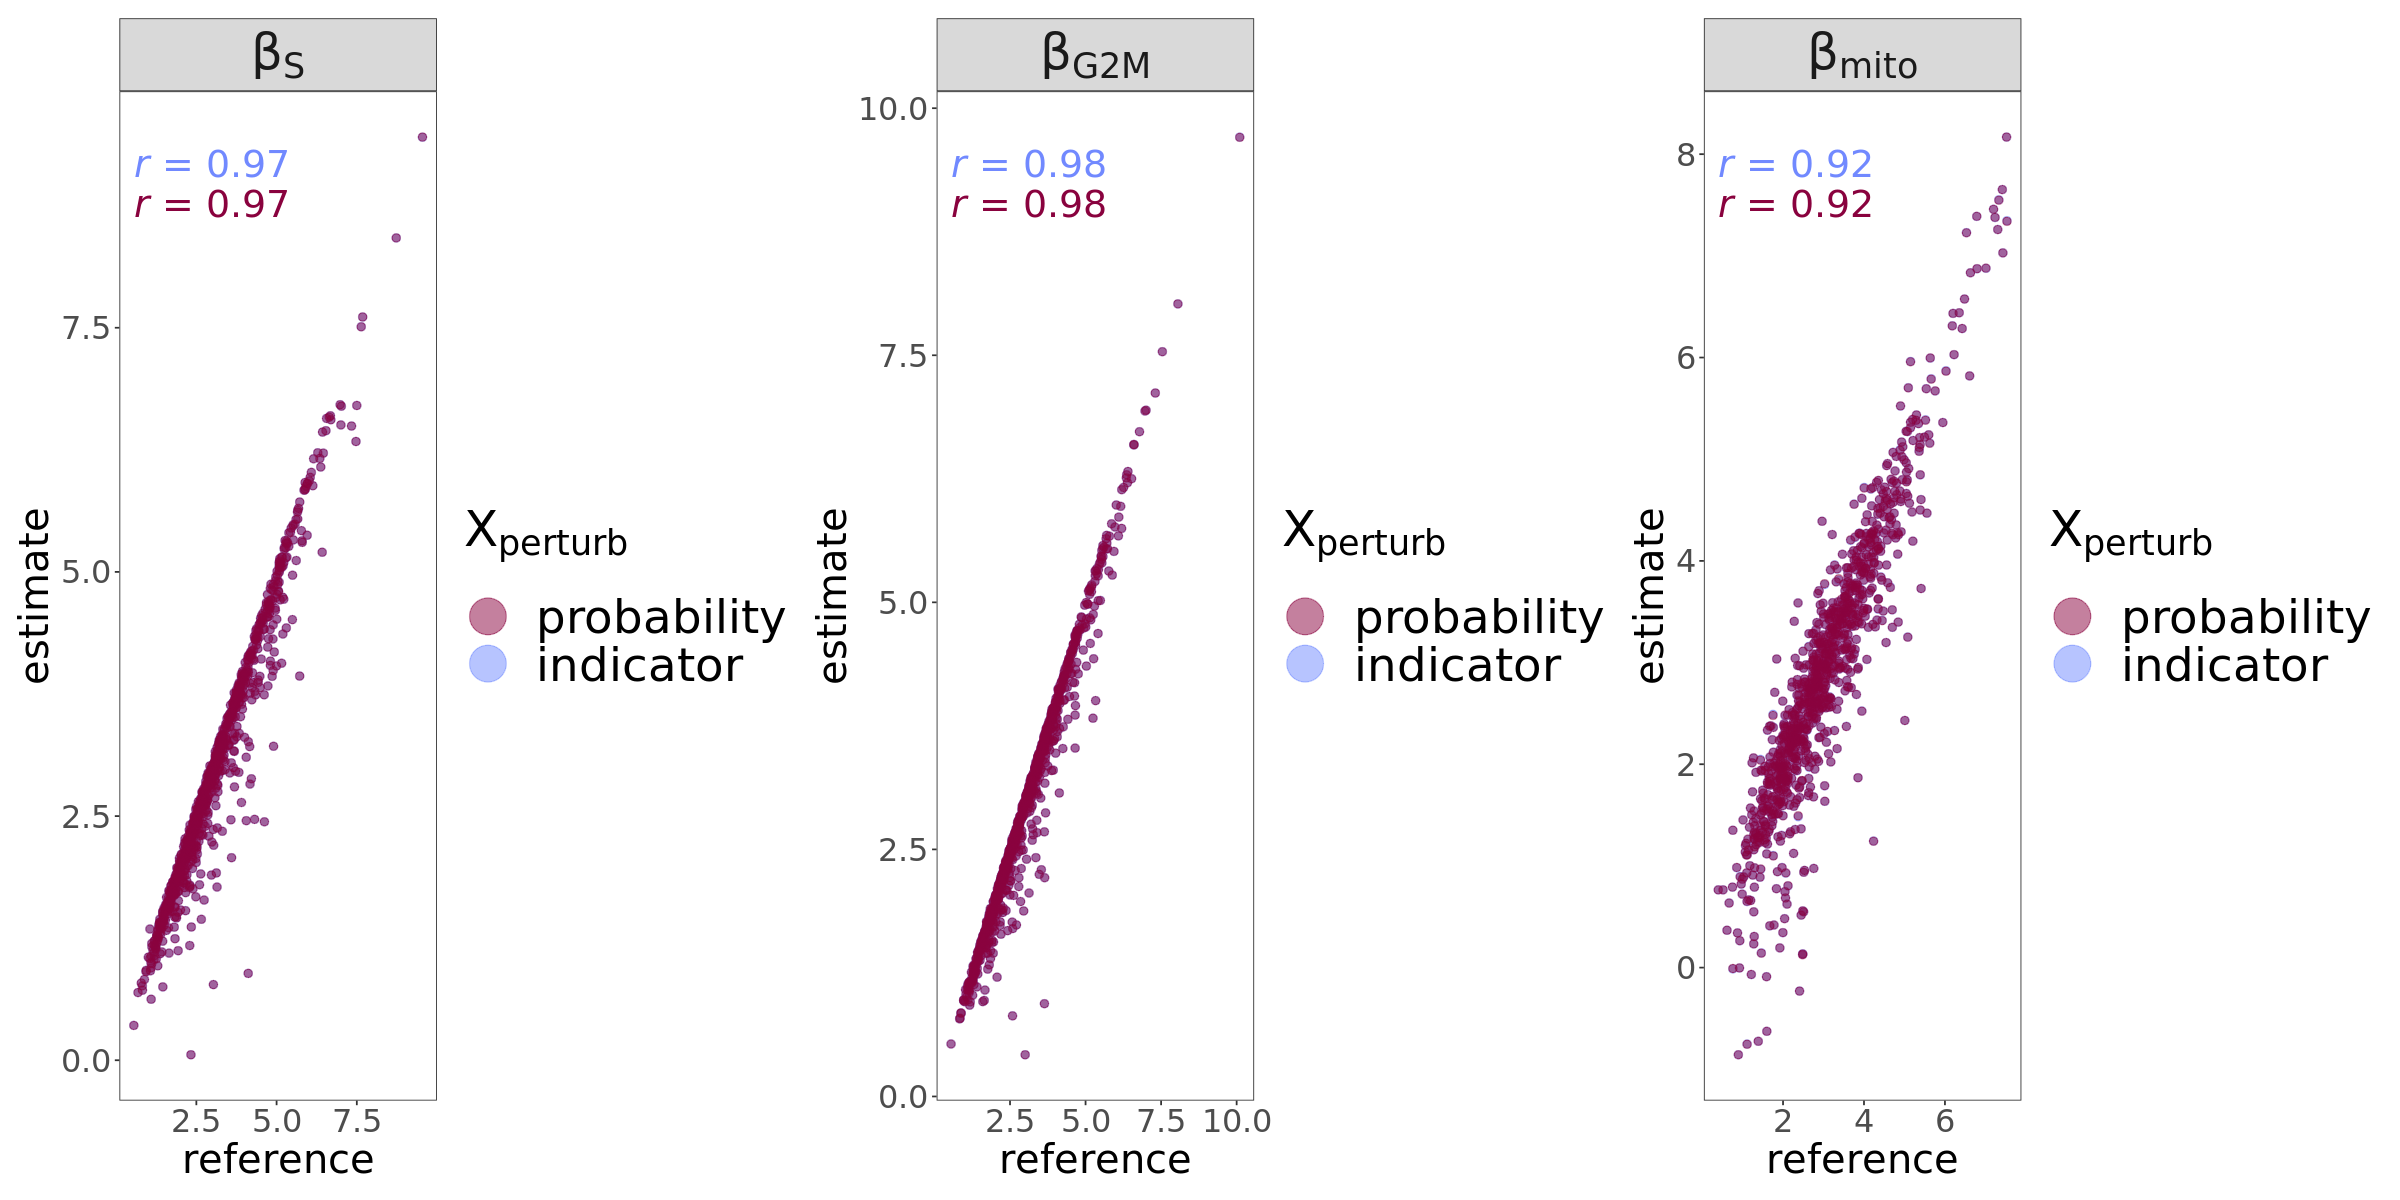

In [15]:
beta.s.p <- plotdf.mod %>% filter(term == "s.score") %>% 
            ggscatter(x = "true", y = "estimate", color = "X.perturb", alpha = 0.5) + 
        stat_cor(method = "pearson", aes(color = X.perturb, label = ..r.label..),
                 show.legend = FALSE, geom = "text", 
                 label.y.npc="top", label.x.npc = "left",
                cor.coef.name = "r",
                 size = 8) + 
            facet_grid(cols=vars(coeff), scales = "free", labeller = label_parsed) +
            theme_bw() +
            theme(text = element_text(size = 24),
                 plot.title = element_text(size = 14),
                 strip.text = element_text(size = 30),
                 legend.text = element_text(size = 28),
                 legend.title = element_text(size = 30),
                 panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
            guides(colour = guide_legend(override.aes = list(size=10))) +
            scale_fill_manual(values=group.colors) + 
            scale_color_manual(values = group.colors) +
            labs(color=expression(paste("X"[perturb])), x='reference') 

beta.g2m.p <- plotdf.mod %>% filter(term == "g2m.score") %>% 
            ggscatter(x = "true", y = "estimate", color = "X.perturb", alpha = 0.5) + 
        stat_cor(method = "pearson", aes(color = X.perturb, label = ..r.label..),
                 show.legend = FALSE, geom = "text", 
                 label.y.npc="top", label.x.npc = "left",
                cor.coef.name = "r",
                 size = 8) + 
            facet_grid(cols=vars(coeff), scales = "free", labeller = label_parsed) +
            theme_bw() +
            theme(text = element_text(size = 24),
                 plot.title = element_text(size = 14),
                 strip.text = element_text(size = 30),
                 legend.text = element_text(size = 28),
                 legend.title = element_text(size = 30),
                 panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
            guides(colour = guide_legend(override.aes = list(size=10))) +
            scale_fill_manual(values=group.colors) + 
            scale_color_manual(values = group.colors) +
            labs(color=expression(paste("X"[perturb])), x='reference') 

beta.mito.p <- plotdf.mod %>% filter(term == "percent.mito") %>% 
            ggscatter(x = "true", y = "estimate", color = "X.perturb", alpha = 0.5) + 
        stat_cor(method = "pearson", aes(color = X.perturb, label = ..r.label..),
                 show.legend = FALSE, geom = "text", 
                 label.y.npc="top", label.x.npc = "left",
                cor.coef.name = "r",
                 size = 8) + 
            facet_grid(cols=vars(coeff), scales = "free", labeller = label_parsed) +
            theme_bw() +
            theme(text = element_text(size = 24),
                 plot.title = element_text(size = 14),
                 strip.text = element_text(size = 30),
                 legend.text = element_text(size = 28),
                 legend.title = element_text(size = 30),
                 panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
            guides(colour = guide_legend(override.aes = list(size=10))) +
            scale_fill_manual(values=group.colors) + 
            scale_color_manual(values = group.colors) +
            labs(color=expression(paste("X"[perturb])), x='reference') 

beta.s.p | beta.g2m.p | beta.mito.p

## Stitch together plots with patchwork

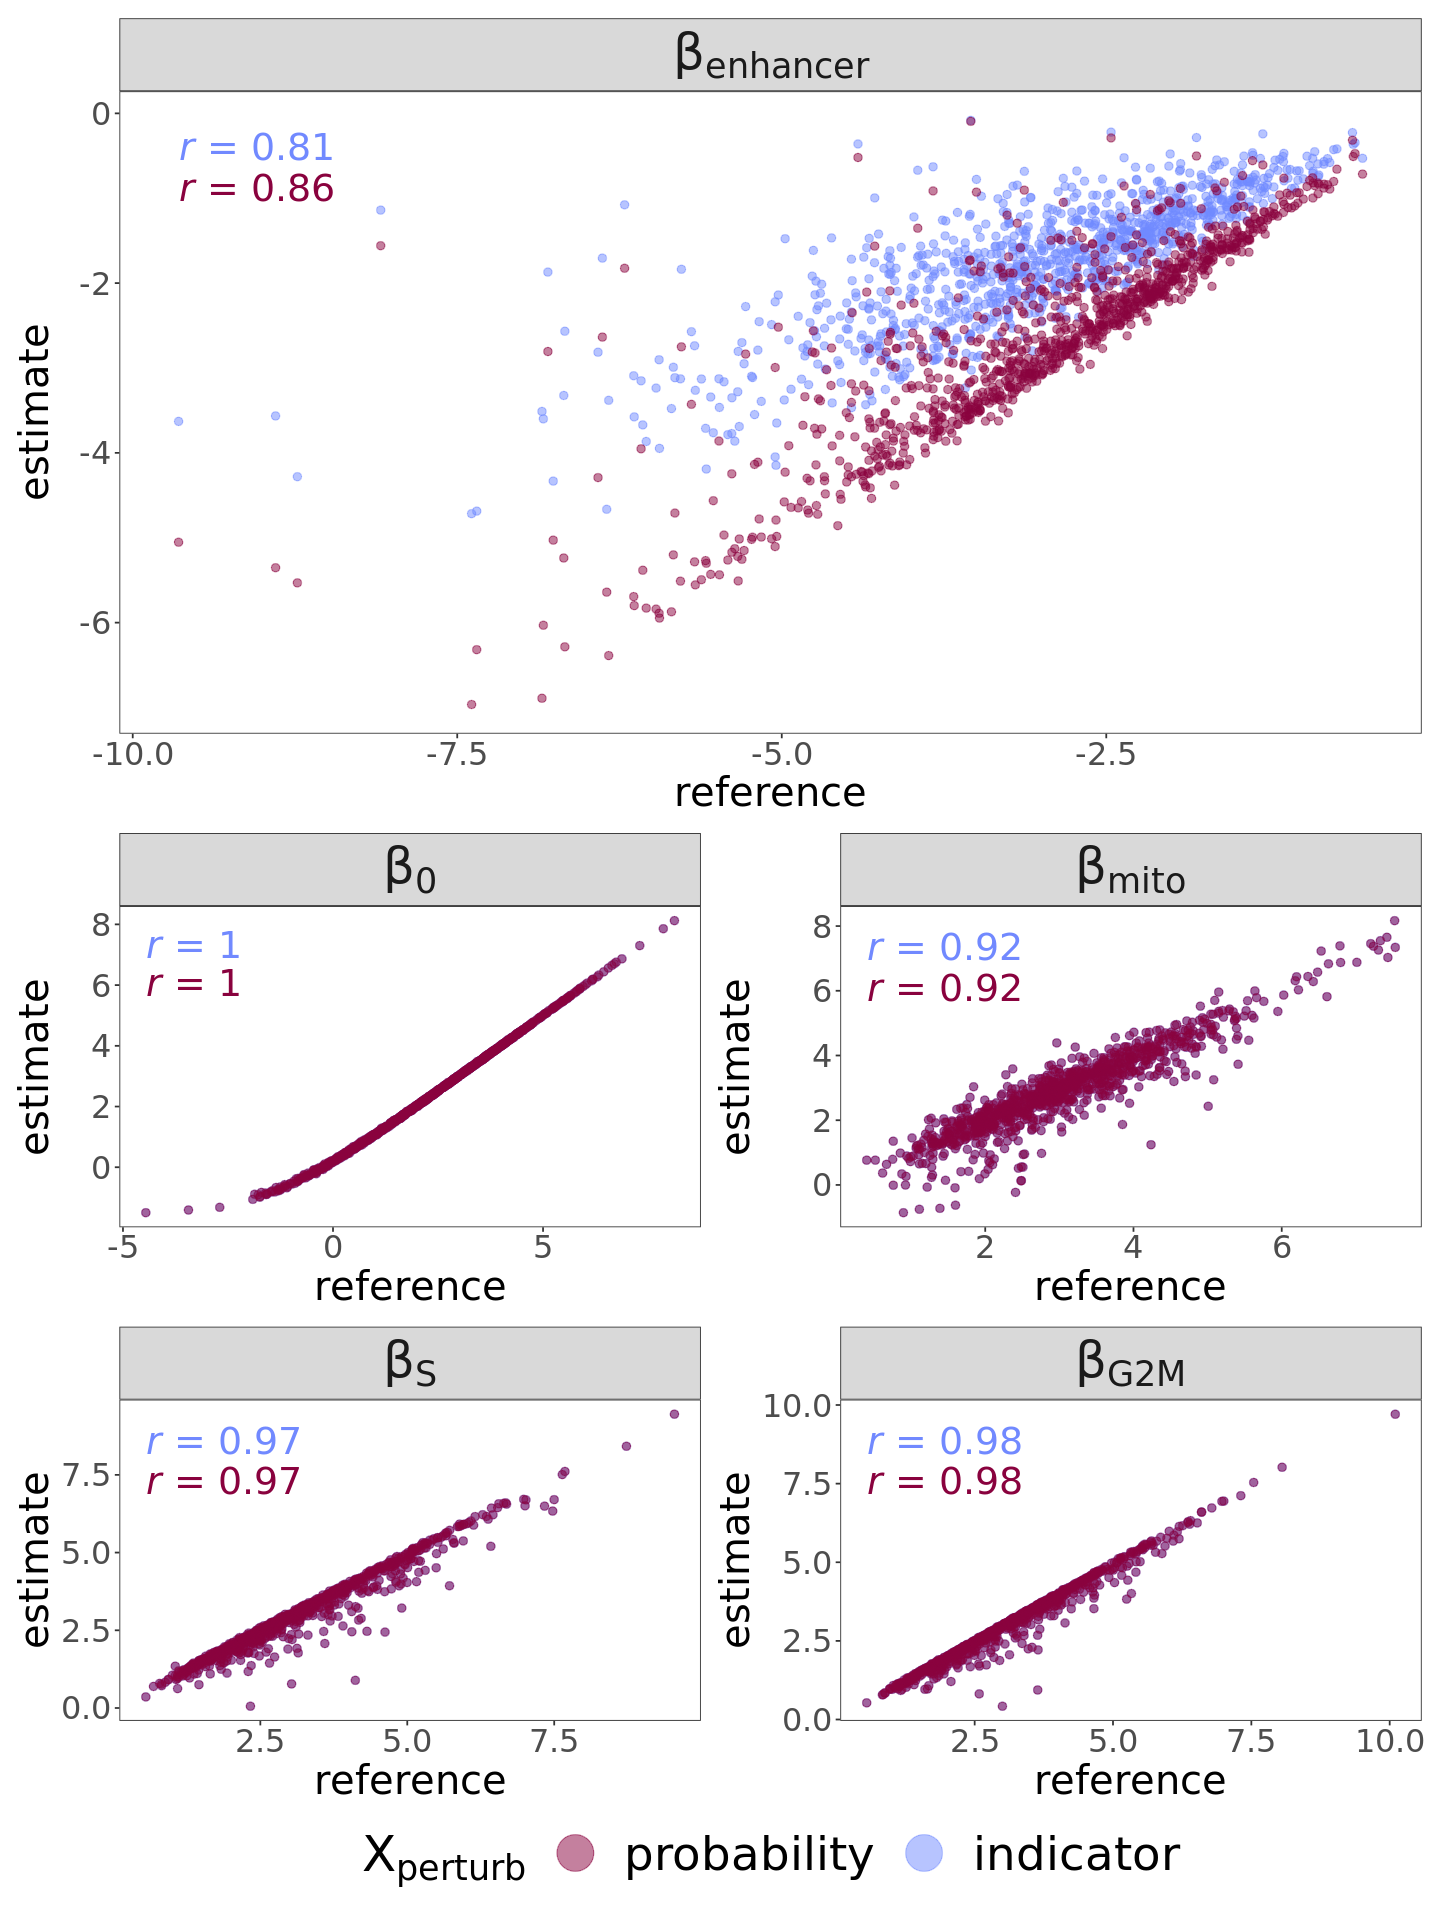

In [16]:
options(repr.plot.width=12, repr.plot.height=16)

design <- "
AAAA
AAAA
BBCC
DDEE
"

beta.enh.p + beta0.p + beta.mito.p + beta.s.p + beta.g2m.p + plot_layout(design = design, guides = "collect") & theme(legend.position = "bottom")



In [17]:
png("/iblm/netapp/data1/jezhou/crisprQTL/revisions_figures/alt_coeffs_scatterplot_cont-counts_prob-vs-indicator-x1_PSEUDOCOUNT_pearson.png", 
    res = 300, units = "in", width = 12, height = 16)

print(
    beta.enh.p + beta0.p + beta.mito.p + beta.s.p + beta.g2m.p + plot_layout(design = design, guides = "collect") & theme(legend.position = "bottom")
)

dev.off()

png 
  2

In [18]:
pdf("/iblm/netapp/data1/jezhou/crisprQTL/revisions_figures/alt_coeffs_scatterplot_cont-counts_prob-vs-indicator-x1_PSEUDOCOUNT_pearson.pdf", 
    width = 12, height = 16)

print(
    beta.enh.p + beta0.p + beta.mito.p + beta.s.p + beta.g2m.p + plot_layout(design = design, guides = "collect") & theme(legend.position = "bottom")
)

dev.off()

png 
  2